# Self-Driving Car Engineer 
## Lucas Gago

## Computer vision

## Project: Advanced Lane Detection



## to do
* meter funcion de imagenes de P2
* Histograma?


In [1]:
import cv2
import glob
import numpy as np
from math import *
import matplotlib.pyplot as plt
import matplotlib.image as mpimage
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import moviepy as mve
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors

%matplotlib inline

# Camera Calibration

In [13]:
def calibrate_camera(cal_images, nx, ny):
    objpoints = []  # 3D points
    imgpoints = []  # 2D points

    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1, 2)

    fname = cal_images[0]
    for fname in cal_images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            imge = cv2.drawChessboardCorners(img, (9,6), corners, ret)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
    
    
    return mtx, dist,imge

def camera_setup():
    cal_images = glob.glob('camera_cal/calibration*.jpg')
    nx, ny = 9, 6
    cam_mtx, cam_dist,imge = calibrate_camera(cal_images, nx, ny)
    return cam_mtx, cam_dist,imge

In [14]:
cal_images = glob.glob('camera_cal/calibration*.jpg')
cam_mtx, cam_dist,imge = camera_setup()
normal_images=[]
undis_images=[]
for i in cal_images:
    img = cv2.imread(i)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    normal_images.append(img)
    undis_images.append(cv2.undistort(img, cam_mtx, cam_dist, None, cam_mtx))
    


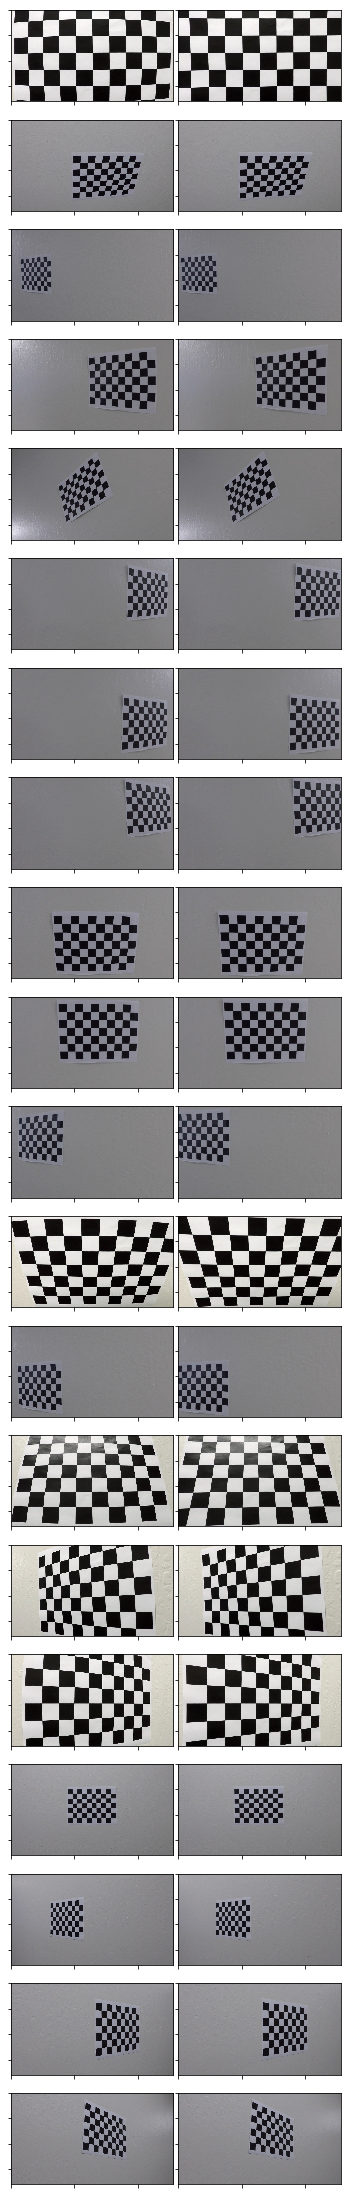

[]

In [15]:
def ShowGrid(X,Y):
    h=len(X)
    w=2
    features_example=[]
    plt.figure(figsize = (6,h*2))
    gs1 = gridspec.GridSpec(h,w)
    gs1.update(wspace=0.002, hspace=0.2)
    count=0
    for i in range(h):
        ax1 = plt.subplot(gs1[count])
        plt.axis('on')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        count+=1
        plt.imshow(X[i])
        ax1 = plt.subplot(gs1[count])
        plt.axis('on')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        plt.imshow(Y[i])
        count+=1
    plt.show()
    return features_example
ShowGrid(normal_images,undis_images)


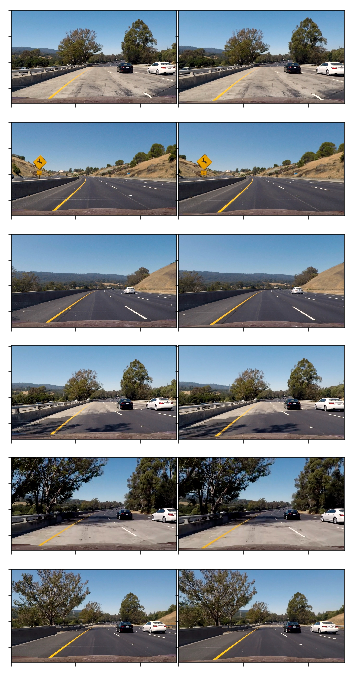

[]

In [16]:
cal_images = glob.glob('test_images/test*.jpg')
normal_images=[]
undis_images=[]
for i in cal_images:
    img = cv2.imread(i)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    normal_images.append(img)
    undis_images.append(cv2.undistort(img, cam_mtx, cam_dist, None, cam_mtx))
    
ShowGrid(normal_images,undis_images)


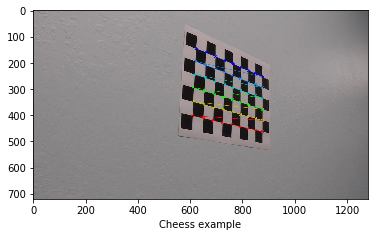

In [88]:
plt.imshow(imge)
plt.xlabel('Cheess example')
plt.show()

# Color and gradient threshold

In [5]:
def hls_color_thresh(img, threshLow, threshHigh):
    imgHLS = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    binary_output = np.zeros((img.shape[0], img.shape[1]))
    binary_output[(imgHLS[:,:,0] >= threshLow[0]) & (imgHLS[:,:,0] <= threshHigh[0])  &
                  (imgHLS[:,:,1] >= threshLow[1]) & (imgHLS[:,:,1] <= threshHigh[1])  & 
                  (imgHLS[:,:,2] >= threshLow[2]) & (imgHLS[:,:,2] <= threshHigh[2])] = 1
                 
    return binary_output

def sobel_x(img, sobel_kernel=3,min_thres = 20, max_thres =100):
    imghsl = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    sobelx1 = cv2.Sobel(imghsl[:,:,1], cv2.CV_64F, 1,0, ksize=sobel_kernel)
    sobelx2 = cv2.Sobel(imghsl[:,:,2], cv2.CV_64F, 1,0, ksize=sobel_kernel)
    scaled_sobelx1 = np.uint8(255*sobelx1/ np.max(sobelx1))
    scaled_sobelx2 = np.uint8(255*sobelx2/ np.max(sobelx2))
    binary_outputx1 = np.zeros_like(scaled_sobelx1)
    binary_outputx1[(scaled_sobelx1 >= min_thres) & (scaled_sobelx1 <= max_thres)] = 1
    binary_outputx2 = np.zeros_like(scaled_sobelx2)
    binary_outputx2[(scaled_sobelx2 >= min_thres) & (scaled_sobelx2 <= max_thres)] = 1
    binary_output = np.zeros_like(scaled_sobelx1)
    binary_output[(binary_outputx1 ==1) | (binary_outputx2 ==1)]=1
    
    return binary_output


def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):    

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1,0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0,1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scaled_sobel = np.uint8(255*gradmag / np.max(gradmag))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1

    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1,0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0,1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    absgraddir = np.arctan2(abs_sobely, abs_sobelx) 
    binary_output = np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    return binary_output

def mag_dir_thresh(img, sobel_kernel=3, mag_thresh=(0, 255), dir_thresh=(0,np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1,0, ksize=sobel_kernel) 
    sobely = cv2.Sobel(img, cv2.CV_64F, 0,1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    absgraddir = np.arctan2(abs_sobely, abs_sobelx) 
    scaled_sobel = np.uint8(255*gradmag / np.max(gradmag))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1]) & (absgraddir >= dir_thresh[0]) & (absgraddir <= dir_thresh[1]) ] = 1

    return binary_output

In [132]:

yellow_low = np.array([0,100,100])
yellow_high = np.array([50,255,255])
white_low = np.array([18,0,180])
white_high = np.array([255,80,255])

def Test_Color_Thres(white_low):
    white_low=hex_to_rgb(white_low)
    print(white_low)
    yellow_low = np.array([0,100,100])
    yellow_high = np.array([50,255,255])
    white_high = np.array([255,80,255])
    img = cv2.imread("test_images/test2.jpg")

    imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    imgThres_yellow = hls_color_thresh(imgRGB,yellow_low,yellow_high)
    imgThres_white = hls_color_thresh(imgRGB,white_low,white_high)


    imgThres_both =np.zeros_like(imgThres_yellow)

    imgThres_both[(imgThres_yellow==1) | (imgThres_white==1)] =1

    plt.figure(figsize=(15,10))

    gs1 = gridspec.GridSpec(2,2)
    gs1.update(wspace=0.02, hspace=0.02)
    ax1 = plt.subplot(gs1[0])
    plt.axis('on')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    plt.imshow(imgThres_yellow,cmap ='gray')
    
    ax1 = plt.subplot(gs1[1])
    plt.axis('on')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    plt.imshow(imgThres_white,cmap ='gray')
    
    ax1 = plt.subplot(gs1[2])
    plt.axis('on')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    plt.imshow(imgThres_both,cmap ='gray')
    
    ax1 = plt.subplot(gs1[3])
    plt.axis('on')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    plt.imshow(imgRGB)

In [133]:
def hex_to_rgb(hex_string):
    rgb = colors.hex2color(hex_string)
    return np.array(tuple([int(255*x) for x in rgb]))

[ 18   0 170]


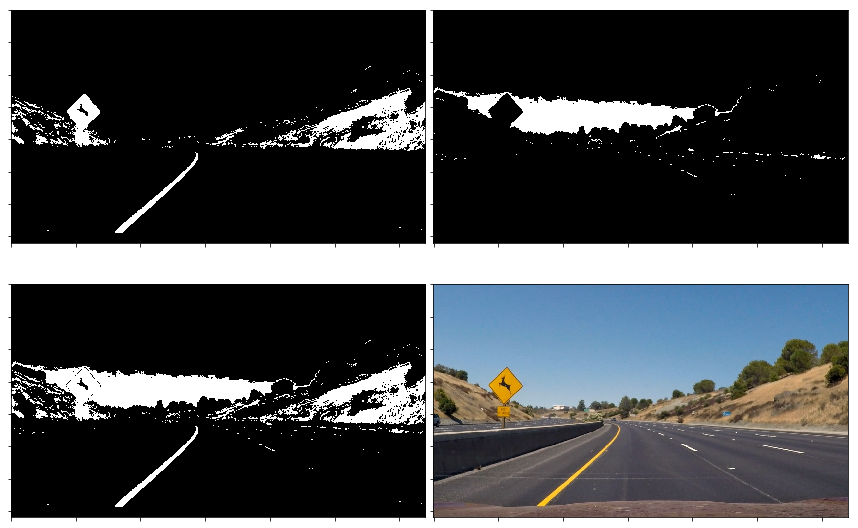

In [135]:
w_low=widgets.ColorPicker(
    description='White Low',concise=False,value='#1200b4'
)

interact(Test_Color_Thres,white_low=w_low)

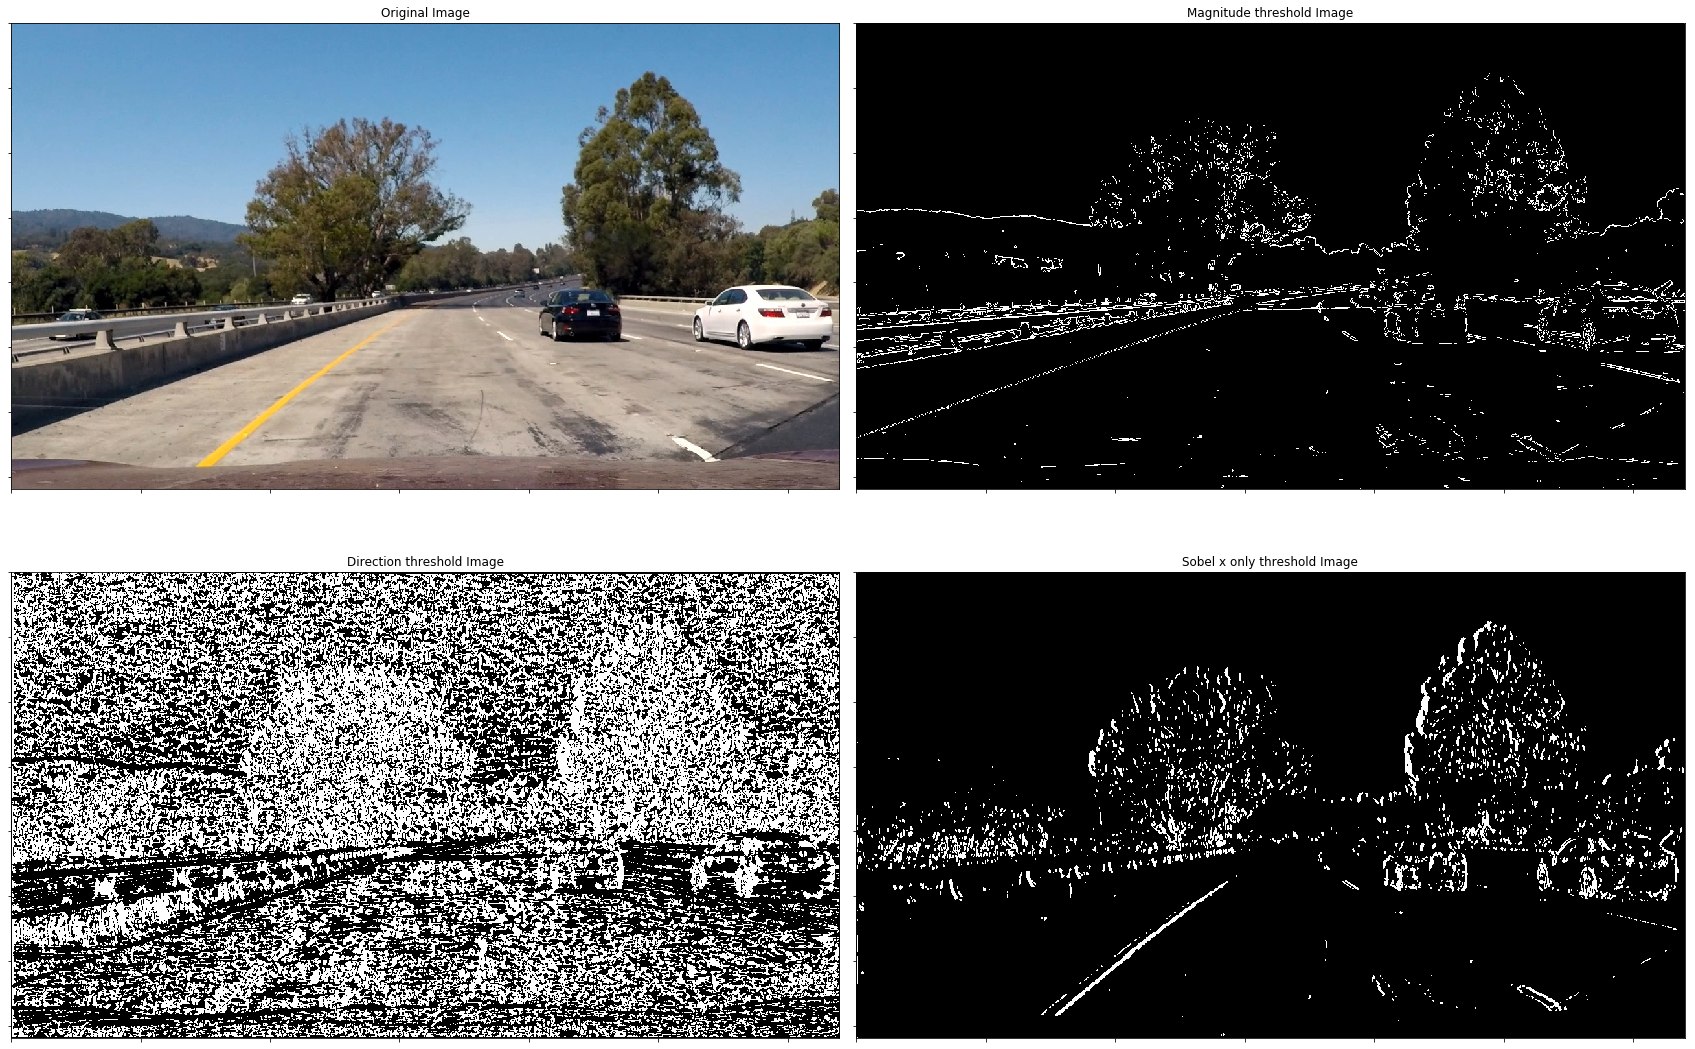

In [136]:
plt.figure(figsize=(10,8))

img = cv2.imread("test_images/test1.jpg")
imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

magThr =mag_thresh(imgRGB, 3, (50, 100))

dirThr =dir_threshold(imgRGB, 9,(np.pi/240/90, np.pi/2*60/90))

imgThr = sobel_x(imgRGB,9,80,220) 

plt.figure(figsize=(30,20))
gs1 = gridspec.GridSpec(2,2)
gs1.update(wspace=0.02, hspace=0.02)
ax1 = plt.subplot(gs1[0])
plt.axis('on')
ax1.set_xticklabels([])
ax1.set_yticklabels([])
plt.title('Original Image')
fig =plt.imshow(imgRGB)

ax1 = plt.subplot(gs1[1])
plt.axis('on')
ax1.set_xticklabels([])
ax1.set_yticklabels([])
plt.title('Magnitude threshold Image')
fig =plt.imshow(magThr,cmap = 'gray')

ax1 = plt.subplot(gs1[2])
plt.axis('on')
ax1.set_xticklabels([])
ax1.set_yticklabels([])
plt.title('Direction threshold Image')
fig =plt.imshow(dirThr,cmap = 'gray')

ax1 = plt.subplot(gs1[3])
plt.axis('on')
ax1.set_xticklabels([])
ax1.set_yticklabels([])
plt.title('Sobel x only threshold Image')
fig =plt.imshow(imgThr,cmap = 'gray')



# Perspective Transformation

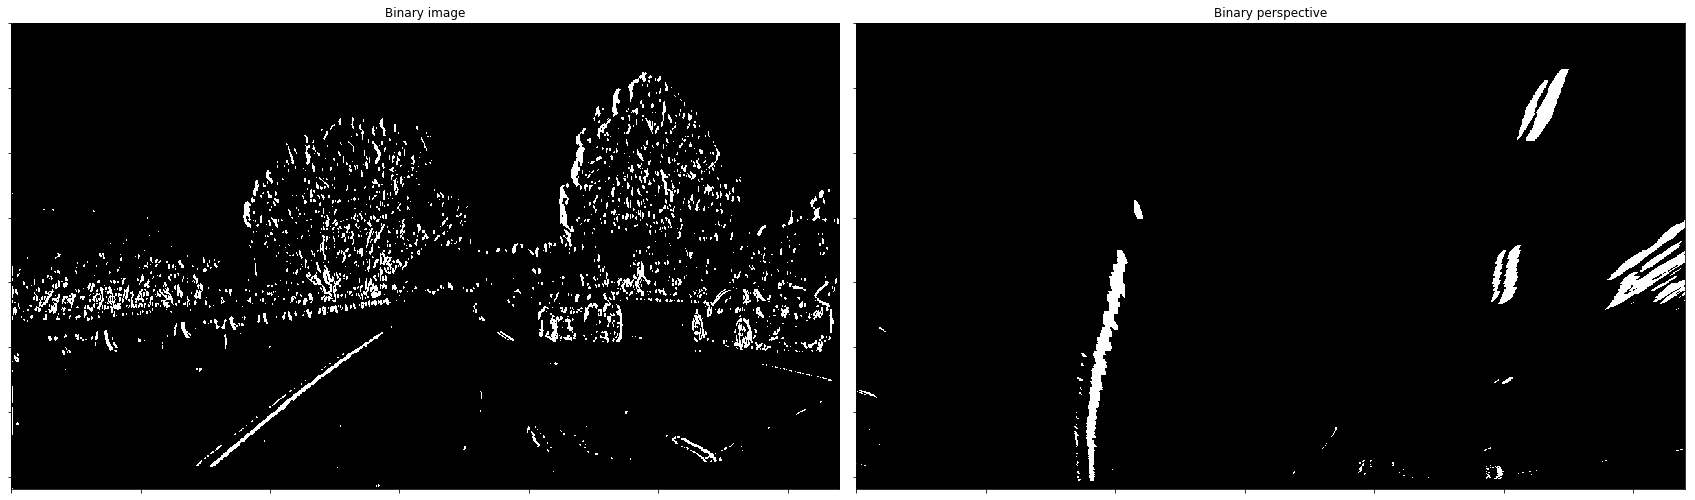

In [137]:
#Perspective transfomation

src = np.float32([[585, 450], [203, 720], [1127, 720], [695, 450]])
dst = np.float32([[320, 0], [320, 720], [960,720], [960, 0]])

M_persp = cv2.getPerspectiveTransform(src, dst)
Minv_persp = cv2.getPerspectiveTransform(dst, src)

img_size = (imgThr.shape[1], imgThr.shape[0])
binary_warped = cv2.warpPerspective(imgThr, M_persp, img_size, flags=cv2.INTER_LINEAR)


plt.figure(figsize=(30,20))

gs1 = gridspec.GridSpec(1,2)
gs1.update(wspace=0.02, hspace=0.02)
ax1 = plt.subplot(gs1[0])
plt.axis('on')
ax1.set_xticklabels([])
ax1.set_yticklabels([])
plt.title('Binary image')
fig =plt.imshow(imgThr, cmap='gray')

ax1 = plt.subplot(gs1[1])
plt.axis('on')
ax1.set_xticklabels([])
ax1.set_yticklabels([])
plt.title('Binary perspective')
fig =plt.imshow(binary_warped, cmap='gray')

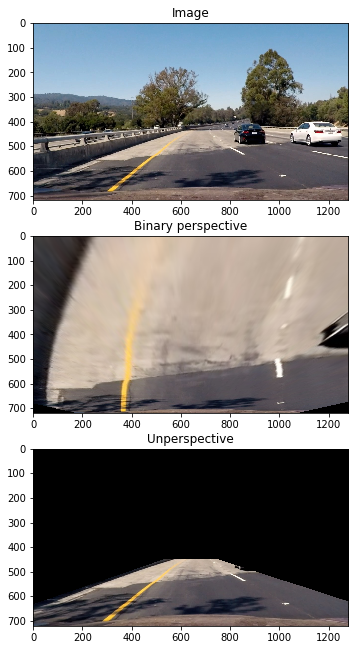

In [159]:
#Perspective transfomation
img = cv2.imread("test_images/test4.jpg")

imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img2 = cv2.undistort(imgRGB, cam_mtx, cam_dist, None, cam_mtx)

img_size = img2.shape[1::-1]

RGB_warped = cv2.warpPerspective(img2, M_persp, img_size, flags=cv2.INTER_LINEAR)


plt.figure(figsize=(20,15))

plt.subplot(4,1,1)
plt.title('Image')
fig =plt.imshow(imgRGB)

plt.subplot(4,1,2)
plt.title('Binary perspective')
fig =plt.imshow(RGB_warped)


img_unpersp = cv2.warpPerspective(RGB_warped, Minv_persp, img_size, flags=cv2.INTER_LINEAR)
plt.subplot(4,1,3)
plt.title('Unperspective')
fig =plt.imshow(img_unpersp)

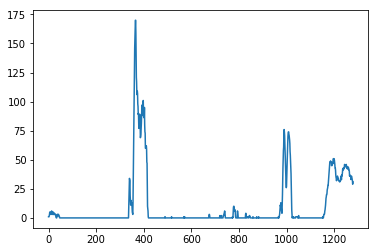

In [160]:
histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
plt.plot(histogram)

In [164]:
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

print("leftx_base: ",leftx_base)
print("rightx_base:",rightx_base)

nwindows = 9
window_height = np.int(binary_warped.shape[0]/nwindows)
nonzero = binary_warped.nonzero()

leftx_base:  365
rightx_base: 990


In [12]:
def fitlines(binary_warped):

    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    nwindows = 9
    window_height = np.int(binary_warped.shape[0]/nwindows)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftx_current = leftx_base
    rightx_current = rightx_base
    margin = 100
    minpix = 50
    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    
    if len(leftx) == 0:
        left_fit =[]
    else:
        left_fit = np.polyfit(lefty, leftx, 2)
    
    if len(rightx) == 0:
        right_fit =[]
    else:
        right_fit = np.polyfit(righty, rightx, 2)
    

    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]


    return left_fit, right_fit,out_img

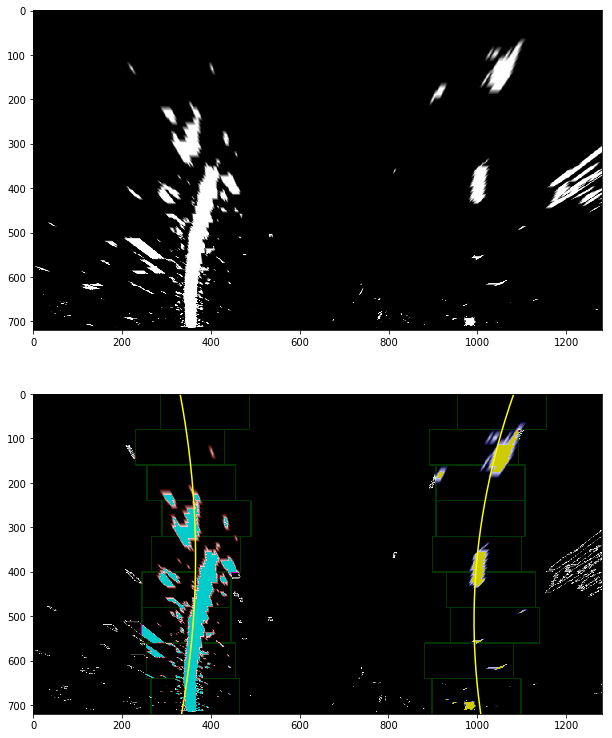

In [13]:
img = cv2.imread("test_images/test1.jpg")
imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img_undist = cv2.undistort(imgRGB, cam_mtx, cam_dist, None, cam_mtx)


yellow_low = np.array([0,100,100])
yellow_high = np.array([50,255,255])
white_low = np.array([18,0,180])
white_high = np.array([255,80,255])
global ref_left 
global ref_right
global left_fit
global right_fit

imgThres_yellow = hls_color_thresh(img_undist,yellow_low,yellow_high)
imgThres_white = hls_color_thresh(img_undist,white_low,white_high)
imgThr_sobelx = sobel_x(img_undist,9,80,220) #Sobel x

img_mag_thr =np.zeros_like(imgThres_yellow)
img_mag_thr[(imgThres_yellow==1) | (imgThres_white==1) | (imgThr_sobelx==1)] =1
img_mag_thr[(imgThres_yellow==1) | (imgThres_white==1)] =1

img_size = (img_mag_thr.shape[1], img_mag_thr.shape[0])
binary_warped = cv2.warpPerspective(img_mag_thr, M_persp, img_size, flags=cv2.INTER_LINEAR)

left_fit, right_fit,out_img = fitlines(binary_warped)

ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    

plt.figure(figsize=(30,20))
plt.subplot(3,1,1)
plt.imshow(binary_warped, cmap='gray')

plt.subplot(3,1,2)

plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

plt.subplot(3,1,2)
binary_warped2 = np.zeros((720, 1280,3))
binary_warped2[:,:,0] = binary_warped
binary_warped2[:,:,1] = binary_warped
binary_warped2[:,:,2] = binary_warped
plt.imshow(out_img)
result = cv2.addWeighted(binary_warped2, .8, out_img, .8, 0)
plt.imshow(result)

In [14]:
def fit_continuous(left_fit, right_fit, binary_warped):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    if len(leftx) == 0:
        left_fit_updated =[]
    else:
        left_fit_updated = np.polyfit(lefty, leftx, 2)
    
    
    if len(rightx) == 0:
        right_fit_updated =[]
    else:
        right_fit_updated = np.polyfit(righty, rightx, 2)
        
    return  left_fit_updated, right_fit_updated

In [15]:
#Calc Curvature
def curvature(left_fit, right_fit, binary_warped):
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    y_eval = np.max(ploty)
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    center = (((left_fit[0]*720**2+left_fit[1]*720+left_fit[2]) +(right_fit[0]*720**2+right_fit[1]*720+right_fit[2]) ) /2 - 640)*xm_per_pix
    
    return left_curverad, right_curverad, center

In [16]:

#Draw line and return image

def drawLine(undist, warped,left_fit, right_fit):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2+left_fit[1]*ploty+left_fit[2]
    right_fitx = right_fit[0]*ploty**2+right_fit[1]*ploty+right_fit[2] 
    
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    cv2.fillPoly(color_warp, np.int_([pts]), (255,215, 0))

    
    newwarp = cv2.warpPerspective(color_warp, Minv_persp, (color_warp.shape[1], color_warp.shape[0])) 


    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    return(result, color_warp)

In [17]:

def sanity_check(left_fit, right_fit, minSlope, maxSlope):

    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    if len(left_fit) ==0 or len(right_fit) == 0:
        status = False
        d0=0
        d1=0
    else:
        L_0 = 2*left_fit[0]*460+left_fit[1]
        R_0 = 2*right_fit[0]*460+right_fit[1]
        d0 =  np.abs(L_0-R_0)

        L_1 = 2*left_fit[0]*720+left_fit[1]
        R_1 = 2*right_fit[0]*720+right_fit[1]
        d1 =  np.abs(L_1-R_1)

        
        if d0>= minSlope and d0<= maxSlope and d1>= minSlope and d1<= maxSlope:
            status = True
        else:
            status = False
            
    return(status, d0, d1)

In [24]:
global counter
counter=0
ref_left =np.array([-0.0001,0,400])
ref_right=np.array([-0.0001,0,1000])   
left_fit =np.array([-0.0001,0,400])
right_fit=np.array([-0.0001,0,1000])   

yellow_low = np.array([0,100,100])
yellow_high = np.array([50,255,255])
white_low = np.array([18,0,180])
white_high = np.array([255,80,255])

def process_image(image,yellow_low=np.array([0,100,100]),yellow_high=np.array([-0.0001,0,1000]),
                  white_low=np.array([-0.0001,0,400]),white_high=np.array([-0.0001,0,1000])   ,
                  sobel_kernel=9,min_thres = 80, max_thres =220,min_slope=0,max_slope=.55):
    #1. Camera correction
    #Calibration arrays pre-calculated
    img_undist = cv2.undistort(image, cam_mtx, cam_dist, None, cam_mtx)
    global counter
    
    #2.Magnitude Threshold
    #Threshold color    
    
    global ref_left 
    global ref_right
    global left_fit
    global right_fit

    imgThres_yellow = hls_color_thresh(img_undist,yellow_low,yellow_high)
    imgThres_white = hls_color_thresh(img_undist,white_low,white_high)
    imgThr_sobelx = sobel_x(img_undist,sobel_kernel,min_thres ,max_thres) #Sobel x

    img_mag_thr =np.zeros_like(imgThres_yellow)
    #imgThresColor[(imgThres_yellow==1) | (imgThres_white==1)] =1
    img_mag_thr[(imgThres_yellow==1) | (imgThres_white==1) | (imgThr_sobelx==1)] =1
        
    #3. Birds-eye
    #Perspective array pre-calculated
    img_size = (img_mag_thr.shape[1], img_mag_thr.shape[0])
    binary_warped = cv2.warpPerspective(img_mag_thr, M_persp, img_size, flags=cv2.INTER_LINEAR)
    
    #4. Detect lanes and return fit curves
    
    if counter==0:
        left_fit, right_fit,out_imgfit = fitlines(binary_warped)
    else:
        left_fit, right_fit = fit_continuous(left_fit, right_fit, binary_warped)
    
    
    
    status_sanity, d0, d1 =sanity_check(left_fit, right_fit, min_slope, max_slope)
    #status_sanity=True
    #print(left_fit)
    #print(right_fit)
    
    #Calc curvature and center
    if status_sanity  == True:        
        #Save as last reliable fit
        ref_left, ref_right = left_fit, right_fit        
        counter+=1
    else:        #Use the last realible fit
        left_fit, right_fit = ref_left, ref_right
        
    left_curv, right_curv, center_off = curvature(left_fit, right_fit, binary_warped)

    #Warp back to original and merge with image    
    img_merge, img_birds = drawLine(img_undist, binary_warped,left_fit, right_fit)

    #Composition of images to final display
    img_out=np.zeros((576,1280,3), dtype=np.uint8)

    img_out[0:576,0:1024,:] =cv2.resize(img_merge,(1024,576))
    #b) Threshold
    img_out[0:288,1024:1280, 0] =cv2.resize(img_mag_thr*255,(256,288))
    img_out[0:288,1024:1280, 1] =cv2.resize(img_mag_thr*255,(256,288))
    img_out[0:288,1024:1280, 2] =cv2.resize(img_mag_thr*255,(256,288))
    #c)Birds eye view
    img_out[310:576,1024:1280,:] =cv2.resize(img_birds,(256,266))
    
    
    #Write curvature and center in image
    TextL = "Left curv: " + str(int(left_curv)) + " m"
    TextR = "Right curv: " + str(int(right_curv))+ " m"
    TextC = "Center offset: " + str(round( center_off,2)) + "m"
    TextAux = str(status_sanity) + ", d0: " + str(round(d0,2)) + ", d1: " + str(round(d1,2))
    fontScale=1
    thickness=2
    
    fontFace = cv2.FONT_HERSHEY_SIMPLEX


    cv2.putText(img_out, TextL, (130,40), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
    cv2.putText(img_out, TextR, (130,70), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
    cv2.putText(img_out, TextC, (130,100), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
    cv2.putText(img_out, TextAux, (100,130), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)

    cv2.putText(img_out, "Thresh. view", (1070,30), fontFace, .8,(200,200,0), thickness,  lineType = cv2.LINE_AA)
    cv2.putText(img_out, "Birds-eye", (1080,305), fontFace, .8,(200,200,0), thickness,  lineType = cv2.LINE_AA)
        
    
    #return img_out, binary_warped, left_curv, right_curv, left_fit, right_fit   
    return img_out

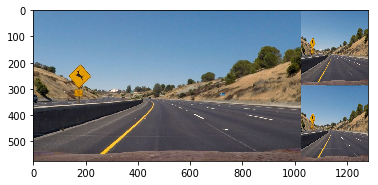

In [25]:
#Test composition images
img = cv2.imread("test_images/test2.jpg")
imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_out=np.zeros((576,1280,3), dtype=np.uint8)

img_out[0:576,0:1024,0:3] =cv2.resize(imgRGB,(1024,576))
#b) Threshold
img_out[0:288,1024:1280, :] =cv2.resize(imgRGB,(256,288))
#c)Birds eye view
img_out[288:576,1024:1280,:] =cv2.resize(imgRGB,(256,288))


#img2 = cv2.resize(imgRGB,(1024,576))
plt.imshow(img_out)

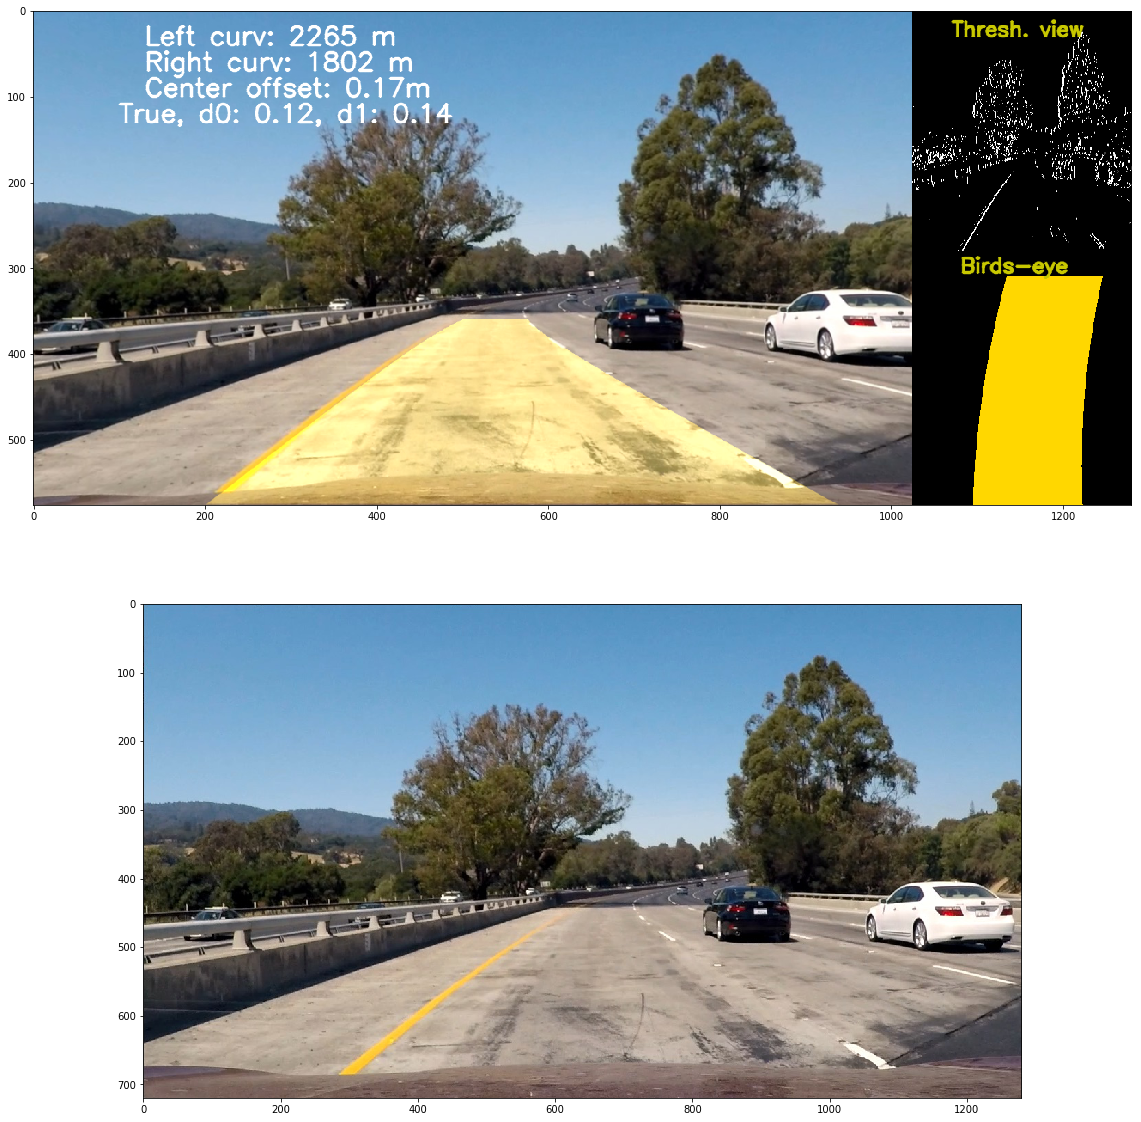

In [26]:

img = cv2.imread("test_images/test1.jpg")
imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img2= process_image(imgRGB)

plt.figure(figsize=(10,15))
#plt.figure(figsize=(5,10))

  
plt.figure(figsize=(30,20))
plt.subplot(2,1,1)
plt.imshow(img2)
plt.subplot(2,1,2)
plt.imshow(imgRGB)

In [30]:
#Create video file pipeline
counter=0
output = 'out_test_video.mp4'
clip1 = VideoFileClip("project_video.mp4").subclip(2,10)
#clip1 = VideoFileClip("project_video.mp4").subclip(22,25)
#clip1 = VideoFileClip("challenge_video.mp4")
clip1 = VideoFileClip("challenge_video.mp4").subclip(2,14)
#clip1 = VideoFileClip("Extra2.mp4").subclip(2,10)

#clip1.save_frame("frame.jpeg")
#clip1 = clip1.fx(mve.vfx.rotate, lambda t: 90*t, expand=False)
out_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time out_clip.write_videofile(output, audio=False)
print(counter)

[MoviePy] >>>> Building video out_test_video.mp4
[MoviePy] Writing video out_test_video.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 360/360 [01:11<00:00,  5.22it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: out_test_video.mp4 

Wall time: 1min 11s
28


In [32]:

HTML("""
<video  width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

In [44]:
from ipywidgets import *
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from IPython.display import display

In [49]:

w=widgets.ColorPicker(
    
    description='Pick a color'
)
display(w)

In [50]:
w.value

'black'

In [169]:

a=widgets.ToggleButtons(
    options=['Slow', 'Regular', 'Fast'],
    description='Speed:',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Description',
#     icon='check'
)
display(a)

In [54]:
a.value

'Slow'